 合并文件，全部放在一起~

# 👒 rembg 抠图移除背景
 - self.instance_images_path = list(Path(instance_data_root).iterdir())
 - 移除背景的与原图需要有对应关系，便于构建reference 模型~
 - !rembg i -m u2netp ../girl100/a1/sa1.jpeg sa1_remedb_output.png

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image, ImageDraw
import torch
from rembg import remove

import mediapipe as mp
from alian_face import mp_align_crop_cv2

mp_face_detection = mp.solutions.face_detection

# -- 使用新的人脸识别-- embedding 模块 -- 计算图片编码~ --- 
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
inference = pipeline("face_recognition", model='bubbliiiing/cv_retinafce_recognition', model_revision='v1.0.3')

#  -- way ||--
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("/home/dell/llm/blip/")      # "image-to-text",model="Salesforce/blip-image-captioning-large", device=0
model = BlipForConditionalGeneration.from_pretrained("/home/dell/llm/blip/").cuda()


## 1.1 👑 resize~ 智能剪裁，保证~目标居中

In [2]:
# -- 该剪裁没法保证目标居中 ~
def crop_image(image, width, height):
    w, h = image.size
    factor = min(w / width, h / height)
    width = int(width * factor)
    height = int(height * factor)
    image = image.crop((
        (w - width) // 2,
        (h - height) // 2,
        (w + width) // 2,
        (h + height) // 2
    ))
    return image

In [3]:
1024 * 1024 - 1280 * 768, 65536 / 256

(65536, 256.0)

In [4]:
target_optional = [[1024, 1024], [768, 1024], [768, 1280]]
#  1 、 rembg img -> gray get box~
#  2 、 use target_optional and img size get most match  target size
#  3 、 use centor and bounding to get caluculate img bounding 
def smart_crop(rembg_img,   target_optional):
    target_width, target_heigt = target_optional[0]     # default w h choose~
    w, h  = rembg_img.size
    image_gray = rembg_img.convert('L')
    # 获取前景区域的边界框 & 宽高~
    bbox = image_gray.getbbox(alpha_only=False)
    left_upx, left_upy , right_btmx, right_btmy =  bbox
    boxw, boxh = right_btmx - left_upx, right_btmy - left_upy
    opt_factor = boxw / boxh
    # -- choose target accoring to box wh
    factor = [(width_ / height_)  for width_, height_ in target_optional]
    factor_mse = [abs(opt_factor - factor_)  for factor_ in factor]
    b_index = factor_mse.index(min(factor_mse))
    target_width, target_heigt = target_optional[b_index] 
    half_width, half_height = target_width // 2 , target_heigt // 2
    
    # -- 计算前景区域中心坐标~~
    center_x = (left_upx + right_btmx) // 2
    center_y = (left_upy + right_btmy) // 2
    
    # -- 计算剪裁区域左上角右下角坐标~
    left   = max(center_x - half_width, 0)     # enough bounding box
    top    = max(center_y - half_height, 0)  if boxh < target_heigt else left_upy
    right  = min(left + target_width,   w)       # all w , <  required right
    bottom = min(top +  target_heigt,   h)       # all w , <  required right
    return (left,  top,  right,  bottom), (target_width, target_heigt)


 main loop to deal the image files~

In [ ]:
# 目标文件的路径
file_path = "../girl100/sa1.jpeg"
input_path = "../girl100/sa1.jpeg"  # 'input.png'
output_path = './sa1_remedb_output.png'

src = "/home/dell/workspace/dataset/girl100/"
target_dir = "/home/dell/workspace/dataset/girl100pure/"
target_face_dir = "/home/dell/workspace/dataset/girl100face/"
target_optional = [[1024, 1024], [768, 1024], [768, 1280]]

# 创建一个 Path 对象
p = Path(src)
tar_p = Path(target_dir)
# 使用 glob 匹配所有文件  #  p.glob('*.py')
files = p.glob('*')
records = []
for file in files:
    if file.suffix not in [".png", ".jpg", ".jpeg"]:
        continue
    img            = Image.open(file)
    w,h            = img.size
    img_name       = file.stem + ".png"
    ori_crop_path  = tar_p / "orig" / img_name
    rmbg_img_path  =  tar_p / "pure" / img_name
    face_crop_path  =  tar_p / "face" / img_name
    # ----- remobe background ------
    output         =   remove(img, post_process_mask=True)   # for better results
    (left, top, right, bottom), (target_width, target_heigt)  = smart_crop(output, target_optional)
    ori_crop_img   = img.crop((left, top, right, bottom))
    rmbg_img_crop  = output.crop((left, top, right, bottom))
    ori_crop_img.resize(size = (target_width, target_heigt)).save(ori_crop_path)
    rmbg_img_crop.resize(size = (target_width, target_heigt)).save(rmbg_img_path)
    # -------face id  -- related -- 
    emb = inference(dict(user=ori_crop_img))[OutputKeys.IMG_EMBEDDING]   # 调用 人脸检测 & 以及编码模型
    cv2_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    croped_aligned_face = mp_align_crop_cv2(cv2_image, mp_face_detection) 
    if croped_aligned_face is not None:
        # no face detected ------
        cv2.imwrite(face_crop_path, croped_aligned_face)
        # aligned_face_pil = Image.fromarray(cv2.cvtColor(croped_aligned_face, cv2.COLOR_BGR2RGB))
    else:
        face_crop_path = None
    # -- log record ---
    records.append([
        file,  w,h,
        ori_crop_path,
        rmbg_img_path,
        target_width, target_heigt,
        face_crop_path, 
        emb
    ])
    # break
    # rmbgcmd = f"rembg i {i} {new_path}"; os.popen(rmbgcmd).read()
    

face_embeds = []
ref_df = pd.DataFrame(records, columns=["path", "ori_w", "ori_h", "ori_crop_path", "rmbg_img_path", "tar_w", "tar_h", "face_path", "emb"])



In [46]:
ref_df["sz"] = ref_df["tar_w"].apply(lambda x: str(x) + "_") + ref_df["tar_h"].apply(lambda x: str(x)) 
ref_df.head()

,path,ori_w,ori_h,ori_crop_path,rmbg_img_path,tar_w,tar_h,sz
0,/home/dell/workspace/dataset/girl100/sc1.jpeg,936,1600,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1280,768_1280
1,/home/dell/workspace/dataset/girl100/sd6.jpeg,1080,2336,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1280,768_1280
2,/home/dell/workspace/dataset/girl100/se1.jpeg,1242,2688,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1280,768_1280
3,/home/dell/workspace/dataset/girl100/sd7.jpeg,1080,2338,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1024,768_1024
4,/home/dell/workspace/dataset/girl100/a3.jpeg,1242,2688,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1280,768_1280


In [47]:
pd.value_counts(ref_df["sz"])

/tmp/ipykernel_35555/4283659516.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(ref_df["sz"])


sz
768_1280     95
768_1024     14
1024_1024     4
Name: count, dtype: int64

In [59]:

img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text=""
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {out_s}")

>> araffe woman in a white shirt and blue skirt holding a white purse


debug check if middle crop is corret ~  an is // 8 

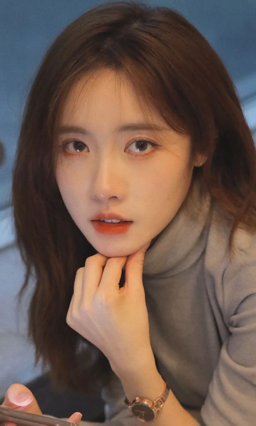

In [7]:
(left, top, right, bottom), (target_width, target_heigt)  = smart_crop(output, target_optional)
# ---- start crop ~~~~~~~
crop_img = img.crop((left, top, right, bottom))
# output_copy = output.copy()
# draw = ImageDraw.Draw(output_copy)
# draw.rectangle(bbox, outline='white')
# draw.rectangle((left, top, right, bottom), outline='green')
# output_copy.convert("RGB").resize(size = (output_copy.size[0]//2, output_copy.size[1]//2))
crop_img.resize(size = (crop_img.size[0]//3, crop_img.size[1]//3))

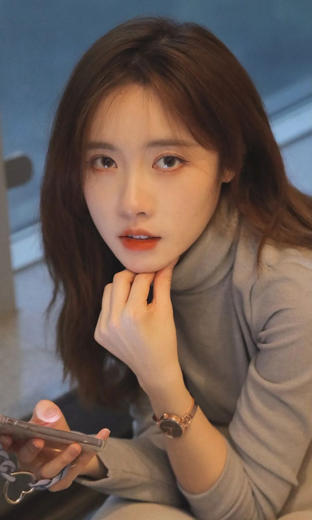

In [8]:
# crop_image(img, target_optional[0])
w_, h_ = target_optional[2]
a_img = crop_image(img, w_, h_)
a_img.resize(size = (a_img.size[0] // 3, a_img.size[1] // 3))


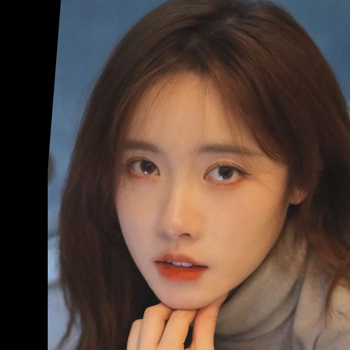

In [20]:
cv2_image = cv2.cvtColor(np.array(crop_img), cv2.COLOR_RGB2BGR)
croped_aligned_face = mp_align_crop_cv2(cv2_image, mp_face_detection)

# new_path_crop = f"{target_face_dir}{img_name}"
# cv2.imwrite(new_path_crop, croped_aligned_face)
pil_image = Image.fromarray(cv2.cvtColor(croped_aligned_face, cv2.COLOR_BGR2RGB))
pil_image.resize(size=(350, 350))

In [72]:
img = Image.open("../girl100/sc6.jpeg")
emb1 = inference(dict(user=pil_image))[OutputKeys.IMG_EMBEDDING]
emb2 = inference(dict(user=a_img))[OutputKeys.IMG_EMBEDDING]
sim = np.dot(emb1[0], emb2[0])
sim
# print(f'Face cosine similarity={sim:.3f}, img1:{img1}  img2:{img2}')

2023-10-25 10:27:37,261 - modelscope - INFO - model inference done
2023-10-25 10:27:37,369 - modelscope - INFO - model inference done


0.9642664

# ✍️ 扣出人脸处理~


In [ ]:
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

# faces[0].bbox 
import mediapipe as mp
from alian_face import mp_align_crop
mp_face_detection = mp.solutions.face_detection

# app = FaceAnalysis(name='buffalo_l')
# app.prepare(ctx_id=0, det_size=(640, 640))
# swapper = insightface.model_zoo.get_model('inswapper_128.onnx', download=True, download_zip=True)


In [50]:
p = Path(src)
# 使用 glob 匹配所有文件  #  p.glob('*.py')
files = p.glob('*')
name_shape = []
for file in files:
    src_img = file   #     '/home/dell/workspace/xl_lora/zdxpure/20230921-142228.jpeg'
    # img = Image.open(src_img)
    img = cv2.imread(src_img)  
    print(img.shape)
    break
    # faces = app.get(img)
    # faces = sorted(faces, key = lambda x : x.bbox[0])
    croped_aligned_face = mp_align_crop(src_img, mp_face_detection)
    img_name = src_img.split("/")[-1]  # .replace("jpeg", "png")
    new_path_crop = f"{target_face_dir}{img_name}"
    cv2.imwrite(new_path_crop, croped_aligned_face)
    
    
    


NameError: name 'src' is not defined

# 👑 Blip2

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
processor = AutoProcessor.from_pretrained("/home/dell/llm/blip2-opt-2.7b/")
model = Blip2ForConditionalGeneration.from_pretrained("/home/dell/llm/blip2-opt-2.7b/", torch_dtype=torch.float16)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#  ------ usage ---------
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

# -------using mulr dialoge -----------
context = [
   ("What is a dinosaur holding?", "a torch"),
   ("Where are they?", "In the woods.")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)





#  😂 试用blip生产图片描述~ 或者用llm多模态生成图片描述~


In [1]:
from PIL import Image
from datasets import load_dataset
from transformers import pipeline
#  -- way ||--
from transformers import BlipProcessor, BlipForConditionalGeneration

# captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-large", device=0)
# captioner = pipeline("image-to-text",model="/home/dell/llm/blip/", device=0)


processor = BlipProcessor.from_pretrained("/home/dell/llm/blip/")
model = BlipForConditionalGeneration.from_pretrained("/home/dell/llm/blip/").cuda()



/home/dell/.conda/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-20 12:03:08.567521: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 12:03:08.619803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# dataset = load_dataset('/home/dell/workspace/T2IAdapter-SDXL-Diffusers/fill50k/fill50kx.py' )
dataset = load_dataset('/home/dell/workspace/T2IAdapter-SDXL/face3w/face3w.py')


In [4]:
processor.tokenizer


Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


BertTokenizerFast(name_or_path='/home/dell/llm/blip/', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
import torch
from PIL import Image

@torch.no_grad()
def caption_image_data_by_text(example):
    text="a face of"
    image = example["image"]
    inputs = processor(image, text, return_tensors="pt")
    for k,v in inputs.items():
        inputs[k] = v.to(model.device)
    out = model.generate(**inputs)
    example['image_caption'] =  processor.decode(out[0], skip_special_tokens=True)
    return example

@torch.no_grad()
def caption_image_data(img_path):
    text="a face of"
    # image = open(img_path, "rb").read()
    image = Image.open(img_path)
    inputs = processor(image, text, return_tensors="pt")
    for k,v in inputs.items():
        inputs[k] = v.to(model.device)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)
    # return example

In [8]:
res = dataset["test"].map(caption_image_data_by_text)
res["image_caption"]

['a face of a man with glasses and a tie',
 'a face of a man with a black hoodie and a blue light',
 'a face of a man with a gray shirt and a tie',
 'a face of a man with a jacket on and a white shirt',
 'a face of a man with glasses and a black jacket',
 'a face of a man with a backpack and a tie']

In [11]:
img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text=""
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {text} {out_s}")

>>  araffe woman in a white shirt and blue skirt holding a white purse


In [15]:
img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text="what view , what lens"
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {out_s}")

>> what view, what lens, what picture, what picture, what picture, what picture, what


# 👒👒 webui tagger 产生tag
-  目前来看需要用caption来完善

In [17]:
from tagger_webui import load_model, load_labels, parse_args, MOAT_MODEL_REPO, MODEL_FILENAME, predict, predictv2
from argparse import Namespace
import functools
from PIL import Image

/home/dell/.conda/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
examples=[["../girl100/a1/sa1.jpeg", "MOAT", 0.35, 0.85]]
global loaded_models
loaded_models = {
    "MOAT": None,    "SwinV2": None,    "ConvNext": None,    "ConvNextV2": None,    "ViT": None,
}
loaded_models[examples[0][1]] = load_model(MOAT_MODEL_REPO, MODEL_FILENAME)

# args = parse_args()
args = args = Namespace(
    score_slider_step = 0.05,
    score_general_threshold = examples[0][2],
    score_character_threshold = examples[0][3],
)
print(">> ", args)
tag_names, rating_indexes, general_indexes, character_indexes = load_labels()
print(f">>, tag_names {len(tag_names)}, rating_indexes {len(rating_indexes)} ,\
        general_indexes {len(general_indexes)}, character_indexes {len(character_indexes)}")

func = functools.partial(
    predictv2,
    tag_names=tag_names,
    rating_indexes=rating_indexes,
    general_indexes=general_indexes,
    character_indexes=character_indexes,
)


>> load model :/home/dell/workspace/dataset/caption/wd-v14-moat-tagger-v2/model.onnx
>>  Namespace(score_slider_step=0.05, score_general_threshold=0.35, score_character_threshold=0.85)
>>, tag_names 9083, rating_indexes 4 ,        general_indexes 6947, character_indexes 2132


2023-10-23 17:35:03.814123085 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-10-23 17:35:03.814147625 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [19]:
img = Image.open(examples[0][0])
model_name = loaded_models[examples[0][1]]
general_threshold = 0.35
character_threshold = 0.85
res = func(img, model_name, general_threshold, character_threshold)

In [20]:
raw_text, cates, rating, character_res, general_res, info = res

In [21]:
import gradio as gr
gr.HTML(info)

html

In [22]:
raw_text

'1girl, solo, long hair, pants, brown hair, jacket, shirt, denim, jewelry, handbag, chair, yellow shirt, earrings, table, brown eyes, standing, window, hand in pocket, looking at viewer, indoors, jeans, holding, bag, white footwear, plant, blue pants, open clothes, lamp, shoes, full body, breasts, building'


# 💕 apply fun to dataset~

In [59]:
import jsonlines as jsl
import pandas as pd

metadata_path = "/home/dell/workspace/T2IAdapter-SDXL-Diffusers/face3w/test.jsonl"

targe_dir = "face3w/"

ds = jsl.open(metadata_path)

metadata = pd.read_json(metadata_path, lines=True)


In [60]:
metadata["text"] = metadata["image"].apply(lambda x: caption_image_data(targe_dir + x))

/home/dell/.conda/envs/sd/lib/python3.8/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [63]:
# cond_path_ = targe_dir + ""
metadata.to_json(metadata_path, orient='records', lines=True)